In [2]:
using MAT, Plots, Images, LinearAlgebra, ImageView, Colors, Statistics, Printf

┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1278
┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1278
┌ Info: Precompiling ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1278


In [3]:
# open file
file = matopen("mnist.mat")
trainX = float64.(read(file, "trainX"))
trainY = float64.(read(file, "trainY"))
testX = float64.(read(file, "testX"))
testY = float64.(read(file, "testY"));

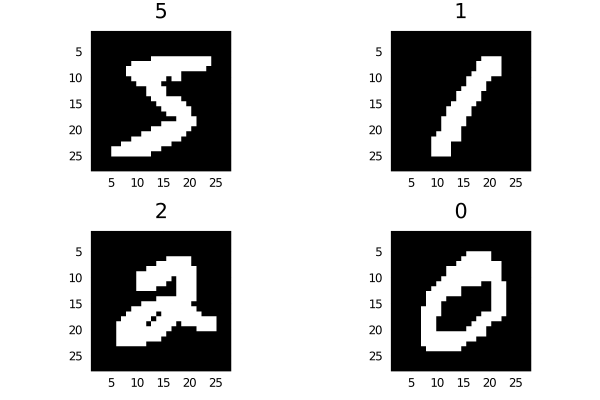

In [4]:
# plot some train images
p = [1 4 6 2]
digit_img = []
for i in 1:4   
    img = reshape(trainX[p[i],:], 28, 28)';
    img = Gray.(img)
    push!(digit_img, heatmap(img))
end
plot(digit_img[1],digit_img[2],digit_img[3],digit_img[4], title = ["5" "1" "2" "0"], axis = false)

In [5]:
# pull out 4s and 9s from train set
idx4 = trainY .== 4 
idx9 = trainY .== 9
idx = idx4 + idx9
idx = findall(x->x == 1, idx[1,:])

A = trainX[idx,:]
b = trainY[idx]

# pull out 4s and 9s from test set
idx4 = testY .== 4 
idx9 = testY .== 9
idx = idx4 + idx9
idx = findall(x->x == 1, idx[1,:])

Atest = testX[idx,:]
btest = testY[idx]

(m,n) = size(A)
mtest = size(Atest,1);

In [6]:
## Preprocess

Aplot = A;
bplot = b;

Amean = mean(A, dims=1);
A = A - ones(m,1)*Amean;
Atest = Atest - ones(mtest,1)*Amean;

b = (b .== 9)*2 .-1;

Astd = std(A, dims=1);
A = A ./ (ones(m,1)*max.(Astd,1));

Atest = Atest./(ones(mtest,1).*max.(Astd,1));
btest = (btest .== 9)*2 .-1;

In [7]:
# linear regression
xLS = A \ b;
pred_train = sign.(A*xLS);
pred_test = sign.(Atest*xLS);
misclass_train = sum(pred_train.!=b) / length(b);
misclass_test = sum(pred_test.!=btest) / length(btest)

0.03566047212456052

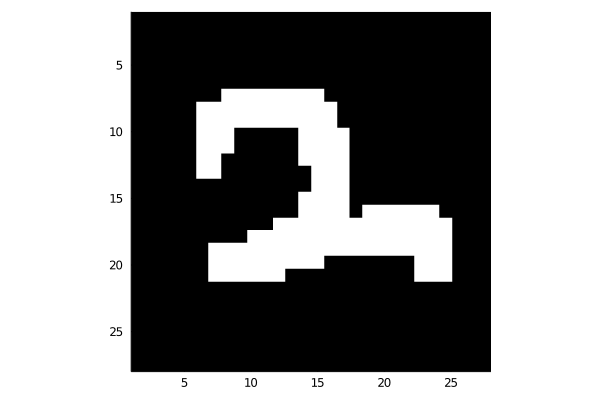

In [8]:
# plot most badly classified example
c,i = findmax(abs.(A*xLS-b));
sample = Aplot[i, :];
sample = reshape(sample, 28, 28);
sample = Gray.(sample);
plot(heatmap(sample))

In [9]:
b = (b .+ 1) ./ 2;
btest = (btest .+ 1) ./ 2;

In [10]:
# logistic regression
ϵ = 1e-10

function f(A, b, x, ϵ)
    z = 1 ./ ( 1 .+ exp.( -A*x ) ) 
    z = min.( 1-ϵ, max.(z , ϵ) )
    return -sum( b .* log.( z ) + (1 .- b) .* log.( 1 .- z ) )
end

function grad(A, b, x, ϵ)
    z = 1 ./ ( 1 .+ exp.( -A*x ) ) 
    z = min.( 1-ϵ, max.(z , ϵ) )
    g =  transpose(A)*(z - b)
    return g
end

function Hessian(A, b, x, ϵ)
    z = 1 ./ ( 1 .+ exp.( -A*x ) ) 
    z = min.( 1-ϵ, max.(z , ϵ) )
    H = transpose(A) * ( (z .* (1 .- z))  .* A)
    return H
end

function misclass(A, b, x)
    pred = sign.(A*x)
    return sum(pred .!= (2*b .- 1))/length(b)
end

misclass (generic function with 1 method)

In [11]:
x0 = zeros( n )
function run_gd( A, Atest, b, btest, f, g, lr ,maxiter = 1000 )
    fn_list = []
    misclass_train_list = []
    misclass_test_list = []
    
    m, n = size(A)
    x = zeros( n )
    for i = 1:maxiter
        x = x - lr * g(A, b, x, ϵ)
        push!(fn_list, f(A, b, x, ϵ))
        push!(misclass_train_list, misclass(A, b, x))
        push!(misclass_test_list, misclass(Atest, btest, x))
        if mod(i,100) == 1
            @printf("iteration = %d, f(x) = %8.2e\n", i, f(A, b, x, ϵ)) 
        end
    end
    return (x =x, 
        fn_list= fn_list, 
        misclass_train_list= misclass_train_list, 
        misclass_test_list = misclass_test_list)
end

run_gd (generic function with 2 methods)

In [12]:
#gradient descent with constant stepsize
Const_GD = run_gd(A, Atest, b, btest, f, grad, 1/m );

iteration = 1, f(x) = 5.31e+03
iteration = 101, f(x) = 7.91e+02
iteration = 201, f(x) = 7.23e+02
iteration = 301, f(x) = 6.86e+02
iteration = 401, f(x) = 6.61e+02
iteration = 501, f(x) = 6.43e+02
iteration = 601, f(x) = 6.28e+02
iteration = 701, f(x) = 6.17e+02
iteration = 801, f(x) = 6.07e+02
iteration = 901, f(x) = 5.98e+02


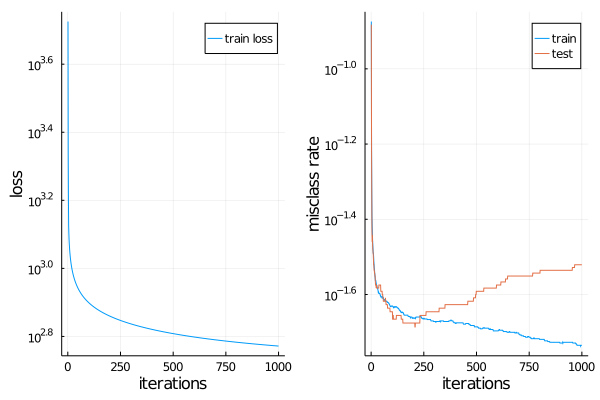

In [13]:
p1 = plot(Const_GD.fn_list, yaxis =:log, xlabel = "iterations", ylabel = "loss", label = "train loss")
p2 = plot(Const_GD.misclass_train_list, yaxis =:log, xlabel = "iterations", ylabel = "misclass rate", label = "train")
plot!(Const_GD.misclass_test_list, yaxis =:log, xlabel = "iterations", ylabel = "misclass rate", label = "test")
plot(p1, p2)


In [14]:
x0 = zeros( n )
function run_gd_linesearch(A, Atest, b, btest, f, g, s, α, β, maxiter = 1000 )
    fn_list = []
    misclass_train_list = []
    misclass_test_list = []
    m, n = size(A)
    x = zeros( n )
    for i = 1:maxiter
        lr = s
        grad = g(A, b, x, ϵ)
        while( f(A, b, x, ϵ) - f(A, b, x - lr * grad, ϵ) < α*lr*norm( grad )^2 )
            lr = lr*β 
        end
        x = x - lr * grad
        push!(fn_list, f(A, b, x, ϵ))
        push!(misclass_train_list, misclass(A, b, x))
        push!(misclass_test_list, misclass(Atest, btest, x))
        if mod(i,100) == 1
            @printf("iteration = %d, f(x) = %8.2e\n", i, f(A, b, x, ϵ)) 
        end
    end
     return (x =x, 
        fn_list= fn_list, 
        misclass_train_list= misclass_train_list, 
        misclass_test_list = misclass_test_list)
end

run_gd_linesearch (generic function with 2 methods)

In [15]:
#gradient descent with backtrack line search
LS = run_gd_linesearch( A, Atest, b, btest, f, grad, 1, 0.5, 0.5 );

iteration = 1, f(x) = 4.47e+03
iteration = 101, f(x) = 6.59e+02
iteration = 201, f(x) = 5.50e+02
iteration = 301, f(x) = 5.32e+02
iteration = 401, f(x) = 5.20e+02
iteration = 501, f(x) = 5.13e+02
iteration = 601, f(x) = 5.07e+02
iteration = 701, f(x) = 5.02e+02
iteration = 801, f(x) = 4.99e+02
iteration = 901, f(x) = 4.96e+02


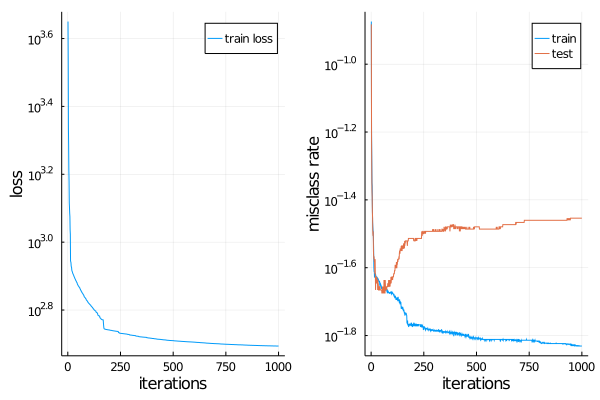

In [16]:
p1 = plot(LS.fn_list, yaxis =:log, xlabel = "iterations", ylabel = "loss", label = "train loss")
p2 = plot(LS.misclass_train_list, yaxis =:log, xlabel = "iterations", ylabel = "misclass rate", label = "train")
plot!(LS.misclass_test_list, yaxis =:log, xlabel = "iterations", ylabel = "misclass rate", label = "test")
plot(p1, p2)